In [1]:
import os
import sys
import numpy as np
from scipy import sparse
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
%config InlineBackend.figure_format = 'svg'
from mpl_toolkits.mplot3d import Axes3D, axes3d
from scipy.cluster import hierarchy
import seaborn as sns
import spacy
import nltk
from konlpy.tag import Okt
import graphviz
from sklearn.utils.fixes import loguniform

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import LatentDirichletAllocation

In [3]:
from sklearn.datasets import load_files

In [ ]:
# CountVectorizer, TfidfVectorizer
# (parameter) lowercase : 모든 문자를 소문자로 변환 여부(default: True)
# (parameter) min_df, max_df : 토큰이 나타날 최소/최대 문서 지정
# (parameter) stop_words : 불용어 지정. ENGLISH_STOP_WORDS import 필요(english, [list], default: None)
# (parameter) tokenizer : 문서의 토큰화를 따로 지정
# (parameter) ngram_range : 토큰의 최소 및 최대 길이((1, 1), (1, 2)...)
# (method) get_feature_names_out : 각 특성에 해당하는 단어를 리스트로 반환

# spacy(import spacy)
# (etc) en_nlp = spacy.load('en_core_web_sm', disable=['parser'])
# (etc) doc_spacy = en_nlp(doc)
# (etc) [token.lemma_ for token in doc_spacy] → tokenizer 파라미터에 함수로 만들어서 지정

# konlpy(from konlpy.tag import Okt) : __setstate__, __getstate__ 메서드 추가 필요
# (etc) okt = PicklableOkt()
# (method) morphs() : 한글의 형태소 분석 메서드

# LatentDirichletAllocation : decomposition 목적으로 사용
# (parameter) n_components : 토픽의 수
# (parameter) learning_method : 학습 방법(online, batch... default: batch)
# (attribution) components_ : 각 단어의 중요도 저장. n_topics, n_words의 크기

In [4]:
reviews_train = load_files('aclImdb/train/')
text_train, y_train = reviews_train['data'], reviews_train['target']
text_train = [doc.replace(b'<br />', b' ') for doc in text_train]

In [5]:
reviews_test = load_files('aclImdb/test/')
text_test, y_test = reviews_test['data'], reviews_test['target']
text_test = [doc.replace(b'<br />', b' ') for doc in text_test]

In [6]:
bards_words = ['The fool doth think he is wise,', 'but the wise man knows himself to be a fool']

In [7]:
vect = CountVectorizer().fit(bards_words)
vect.vocabulary_, len(vect.vocabulary_)

({'the': 9,
  'fool': 3,
  'doth': 2,
  'think': 10,
  'he': 4,
  'is': 6,
  'wise': 12,
  'but': 1,
  'man': 8,
  'knows': 7,
  'himself': 5,
  'to': 11,
  'be': 0},
 13)

In [8]:
vect.transform(bards_words).toarray()

array([[0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1],
       [1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]], dtype=int64)

In [9]:
vect = CountVectorizer().fit(text_train)
X_train = vect.transform(text_train)
X_train

<25000x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 3431196 stored elements in Compressed Sparse Row format>

In [10]:
vect.get_feature_names_out()

array(['00', '000', '0000000000001', ..., 'østbye', 'über', 'üvegtigris'],
      dtype=object)

In [11]:
[text_train[i] for i in np.argwhere(X_train[:, 9] == 1)[:, 0]]

[b'"Dutch Schultz", AKA Arthur Fleggenheimer, was a real person and his rather nasty life is fairly well documented. This movie which purports to depict his life should have used a fictional character, because the overdramatized events are too strong a departure from the facts and the chronology. Not only that, it ignores some interesting details which other versions have included such as the public relations fiasco in upstate N.Y. and his religious conversion. It is true that he was executed by Luciano, Lansky, et. al. but that\'s as far as it goes. The exploding plate scene which represents Luciano carrying out the execution of Bo Weinberg in his own home, assisted by his own mother is rediculous. Also, there is the scene in which Dutch approaches his own mother to pay protection to Legs Diamond. It just doesn\'t work. The character of Mrs. Fleggenheimer doesn\'t work either. This movie does not need a doting Jewish mother for comic relief. The lame representation of Legs Diamond was

In [12]:
np.argwhere(X_train[:, 9] == 1)[:, 0]

array([  554,  6583,  7758,  9637, 10764, 15068, 16627, 17873, 22458,
       23321, 23473])

In [13]:
scores = cross_val_score(LogisticRegression(max_iter=1000), X_train, y_train, n_jobs=-1)
np.mean(scores)

0.88132

In [14]:
param_grid = {'C':[0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid=param_grid, cv=5, n_jobs=-1).fit(X_train, y_train)
grid.best_score_, grid.best_params_

(0.8881599999999998, {'C': 0.1})

In [15]:
X_test = vect.transform(text_test)
grid.score(X_test, y_test)

0.87896

In [16]:
vect = CountVectorizer(min_df=5).fit(text_train)
X_train = vect.transform(text_train)
X_test = vect.transform(text_test)
X_train

<25000x27271 sparse matrix of type '<class 'numpy.int64'>'
	with 3354014 stored elements in Compressed Sparse Row format>

In [17]:
vect.get_feature_names_out()

array(['00', '000', '007', ..., 'zuniga', 'zwick', 'émigré'], dtype=object)

In [18]:
param_grid = {'C':[0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid=param_grid, cv=5, n_jobs=-1).fit(X_train, y_train)
grid.best_score_, grid.best_params_

(0.88812, {'C': 0.1})

In [19]:
len(ENGLISH_STOP_WORDS)

318

In [20]:
vect = CountVectorizer(min_df=5, stop_words='english').fit(text_train)
X_train = vect.transform(text_train)
X_test = vect.transform(text_test)
X_train

<25000x26966 sparse matrix of type '<class 'numpy.int64'>'
	with 2149958 stored elements in Compressed Sparse Row format>

In [21]:
param_grid = {'C':[0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid=param_grid, cv=5, n_jobs=-1).fit(X_train, y_train)
grid.best_score_, grid.best_params_

(0.8828400000000001, {'C': 0.1})

In [22]:
pipe = make_pipeline(TfidfVectorizer(min_df=5), LogisticRegression(max_iter=5000))

In [23]:
param_grid = {'logisticregression__C':[0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(pipe, param_grid=param_grid, n_jobs=-1).fit(text_train, y_train)
grid.best_score_, grid.best_params_, grid.score(text_test, y_test)

(0.8918800000000001, {'logisticregression__C': 10}, 0.88096)

In [24]:
vect = grid.best_estimator_.named_steps['tfidfvectorizer']
X_train = vect.transform(text_train)

In [25]:
sorted_by_tfidf = X_train.max(axis=0).toarray().ravel().argsort()
feature_names = vect.get_feature_names_out()

In [26]:
feature_names[sorted_by_tfidf[:20]], feature_names[sorted_by_tfidf[-20:]]

(array(['suplexes', 'gauche', 'hypocrites', 'oncoming', 'songwriting',
        'galadriel', 'emerald', 'mclaughlin', 'sylvain', 'oversee',
        'cataclysmic', 'pressuring', 'uphold', 'thieving', 'inconsiderate',
        'ware', 'denim', 'reverting', 'booed', 'spacious'], dtype=object),
 array(['gadget', 'sucks', 'zatoichi', 'demons', 'lennon', 'bye', 'dev',
        'weller', 'sasquatch', 'botched', 'xica', 'darkman', 'woo',
        'casper', 'doodlebops', 'smallville', 'wei', 'scanners', 'steve',
        'pokemon'], dtype=object))

In [27]:
feature_names[np.argsort(vect.idf_)[:100]]

array(['the', 'and', 'of', 'to', 'this', 'is', 'it', 'in', 'that', 'but',
       'for', 'with', 'was', 'as', 'on', 'movie', 'not', 'have', 'one',
       'be', 'film', 'are', 'you', 'all', 'at', 'an', 'by', 'so', 'from',
       'like', 'who', 'they', 'there', 'if', 'his', 'out', 'just',
       'about', 'he', 'or', 'has', 'what', 'some', 'good', 'can', 'more',
       'when', 'time', 'up', 'very', 'even', 'only', 'no', 'would', 'my',
       'see', 'really', 'story', 'which', 'well', 'had', 'me', 'than',
       'much', 'their', 'get', 'were', 'other', 'been', 'do', 'most',
       'don', 'her', 'also', 'into', 'first', 'made', 'how', 'great',
       'because', 'will', 'people', 'make', 'way', 'could', 'we', 'bad',
       'after', 'any', 'too', 'then', 'them', 'she', 'watch', 'think',
       'acting', 'movies', 'seen', 'its', 'him'], dtype=object)

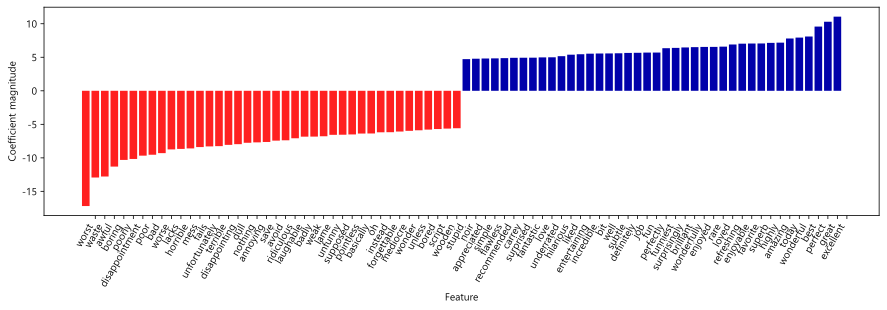

In [28]:
mglearn.tools.visualize_coefficients(grid.best_estimator_.named_steps['logisticregression'].coef_[0],
                                    feature_names, n_top_features=40)

In [29]:
pipe = make_pipeline(TfidfVectorizer(min_df=5), LogisticRegression(max_iter=5000))

In [30]:
param_grid = {'tfidfvectorizer__ngram_range':[(1, 1), (1, 2), (1, 3)], 'logisticregression__C':[0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(pipe, param_grid=param_grid, n_jobs=-1).fit(text_train, y_train)
grid.best_score_, grid.best_params_, grid.score(text_test, y_test)

(0.9063599999999999,
 {'logisticregression__C': 10, 'tfidfvectorizer__ngram_range': (1, 3)},
 0.90364)

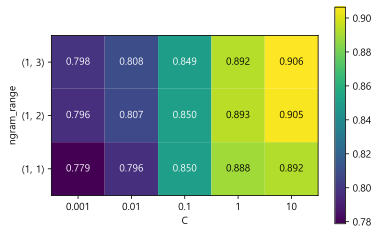

In [31]:
scores = grid.cv_results_['mean_test_score'].reshape(-1, 3).T
heatmap = mglearn.tools.heatmap(scores, xlabel='C', ylabel='ngram_range', cmap='viridis', fmt='%.3f',
                               xticklabels=param_grid['logisticregression__C'],
                               yticklabels=param_grid['tfidfvectorizer__ngram_range'])
plt.colorbar(heatmap)

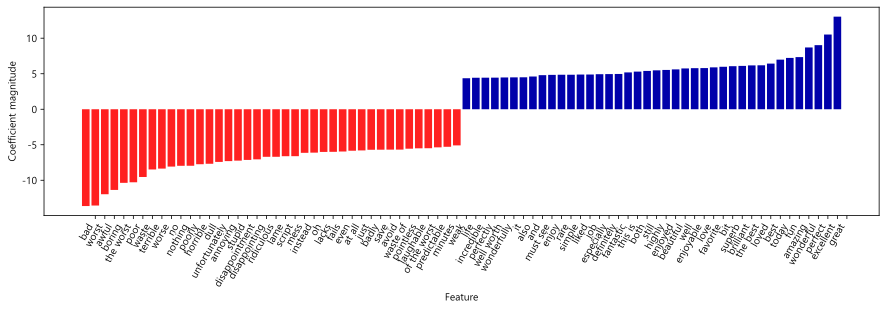

In [32]:
vect = grid.best_estimator_.named_steps['tfidfvectorizer']
feature_names = vect.get_feature_names_out()
coef = grid.best_estimator_.named_steps['logisticregression'].coef_
mglearn.tools.visualize_coefficients(coef[0], feature_names, n_top_features=40)

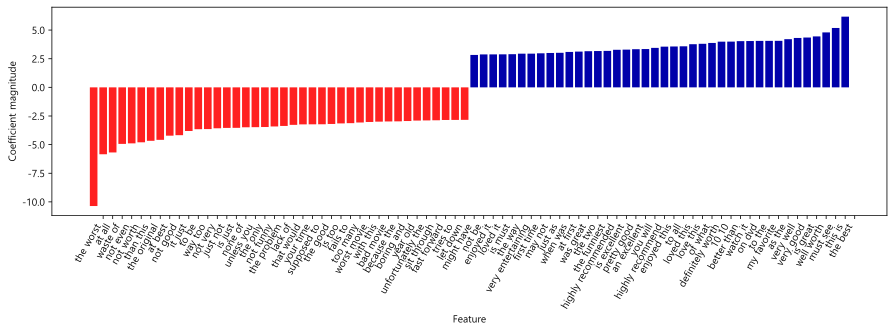

In [33]:
mask = np.array([len(feature.split(' ')) for feature in feature_names]) == 2
mglearn.tools.visualize_coefficients(coef.ravel()[mask], feature_names[mask], n_top_features=40)

In [34]:
en_nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [35]:
document = "Out meeting today was worse than yesterday, I'm scared of meeting the clients tomorrow."
[token.lemma_ for token in en_nlp(document)]

['out',
 'meeting',
 'today',
 'be',
 'bad',
 'than',
 'yesterday',
 ',',
 'I',
 'be',
 'scared',
 'of',
 'meet',
 'the',
 'client',
 'tomorrow',
 '.']

In [36]:
def custom_tokenizer(document):
    doc_spacy = en_nlp(document)
    return [token.lemma_ for token in doc_spacy]

In [37]:
lemma_vect = CountVectorizer(tokenizer=custom_tokenizer, min_df=5).fit(text_train)
X_train_lemma = lemma_vect.transform(text_train)
X_train_lemma.shape

C:\Users\admin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(25000, 21887)

In [38]:
df_train = pd.read_csv('naver/ratings_train.txt', delimiter='\t', keep_default_na=False)
text_train, y_train = df_train['document'].values, df_train['label'].values
df_test = pd.read_csv('naver/ratings_test.txt', delimiter='\t', keep_default_na=False)
text_test, y_test = df_test['document'].values, df_test['label'].values

In [39]:
class PicklableOkt(Okt):
    def __init__(self, *args):
        self.args = args
        Okt.__init__(self, *args)
    def __setstate__(self, state):
        self.__init__(*state['args'])
    def __getstate__(self):
        return {'args':self.args}

In [40]:
okt = PicklableOkt()

In [41]:
param_grid = {'tfidfvectorizer__min_df':[3, 5, 7],
             'tfidfvectorizer__ngram_range':[(1, 1), (1, 2), (1, 3)],
             'logisticregression__C':[0.1, 1, 10]}
pipe = make_pipeline(TfidfVectorizer(tokenizer=okt.morphs), LogisticRegression(max_iter=1000))

In [42]:
grid = GridSearchCV(pipe, param_grid=param_grid, n_jobs=-1).fit(text_train[:1000], y_train[:1000])
grid.best_score_, grid.best_params_

(0.718,
 {'logisticregression__C': 1,
  'tfidfvectorizer__min_df': 3,
  'tfidfvectorizer__ngram_range': (1, 3)})

In [43]:
tfidfvectorizer = grid.best_estimator_.named_steps['tfidfvectorizer']
X_test = tfidfvectorizer.transform(text_test[:1000])
logisticregression = grid.best_estimator_.named_steps['logisticregression']
logisticregression.score(X_test, y_test[:1000])

0.714

In [63]:
text_train, y_train = reviews_train['data'], reviews_train['target']
text_train = [doc.replace(b'<br />', b' ') for doc in text_train]
text_test, y_test = reviews_test['data'], reviews_test['target']
text_test = [doc.replace(b'<br />', b' ') for doc in text_test]
vect = CountVectorizer(max_features=10000, max_df=0.15)
X = vect.fit_transform(text_train)

In [64]:
lda100 = LatentDirichletAllocation(n_components=100, learning_method='batch', max_iter=25, random_state=0, n_jobs=-1)
document_topics100 = lda100.fit_transform(X)

In [65]:
topics = np.array([7, 16, 24, 25, 28, 36, 37, 41, 45, 51, 53, 54, 63, 89, 97])
sorting = np.argsort(lda100.components_, axis=1)[:, ::-1]
feature_names = vect.get_feature_names_out()

In [69]:
mglearn.tools.print_topics(topics=topics, feature_names=feature_names, sorting=sorting, topics_per_chunk=8, n_words=20)

topic 7       topic 16      topic 24      topic 25      topic 28      topic 36      topic 37      topic 41      
--------      --------      --------      --------      --------      --------      --------      --------      
zombie        worst         young         woman         beautiful     play          page          brother       
zombies       money         us            gets          scenery       performance   fu            andy          
dead          waste         our           wife          grey          role          lynch         scott         
george        awful         hitler        house         before        actor         kung          brothers      
johnny        want          world         home          between       actors        silent        hardy         
scooby        nothing       family        girl          spanish       cast          bettie        laurel        
doo           thing         years         goes          each          director      chaplin     

In [71]:
music = np.argsort(document_topics100[:, 45])[::-1]
for i in music[:10]:
    print(b'.'.join(text_train[i].split(b'.')[:2]) + b'\n')

b'Delightful film directed by some of the best directors in the industry today. The film is also casting some of the great actors of our time, not just from France but from everywhere\n'
b'Fairly funny Jim Carrey vehicle that has him as a News reporter who temporarily gets the power of God and wrecks havoc. Carrey is back in familiar ground here and looks to be having a good time, and Jennifer Aniston as his put upon girlfriend is also charming and affecting\n'
b'Busy Phillips put in one hell of a performance, both comedic and dramatic. Erika Christensen was good but Busy stole the show\n'
b"`Bruce Almighty' will sweep the Academy Awards with a record 14 Oscar wins! It will surpass `Titanic' as the highest grossing film of all time! Jim Carrey's illustriousness will be at such a supreme level that he will announce his presidential candidacy for the 2004 White House playoffs. Almighty then! These grandeur fantasies would only transpire if the filmmakers (Carrey included) would possess t

In [72]:
lda = LatentDirichletAllocation(n_components=10, learning_method='batch', max_iter=25, random_state=0, n_jobs=-1)
document_topics = lda.fit_transform(X)

In [73]:
vect.get_feature_names_out()

array(['00', '000', '10', ..., 'zoom', 'zorro', 'zu'], dtype=object)